### Perform EDA and analysis
**program:** 05_rf_mod_h100<br>
**author:** chris chan<br>
**date:** jan 27,2021<br>
**desc:** use clean df for analysis <br>

**datasources:**<br>
- sb_analytic (balanced df thru 2010)
- billboard analytic (hot 100 thru 2019)
- spotify random (random thru 2020)

- decision trees : https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-understanding-decision-trees-adb2165ccab7
- gridsearch cv: https://towardsdatascience.com/understanding-decision-tree-classification-with-scikit-learn-2ddf272731bd
- random forest : https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76
- model eval : https://towardsdatascience.com/how-to-best-evaluate-a-classification-model-2edb12bcc587

**random forest workflow (kf cv)**<br>
1. split 2 times (train,val,test)
2. select features / label
3. standardize if necessary
4. define grid parameters
5. instantiate your model
6. use randomizedsearchcv to tune your hyperparams based on grid params (4)
7. FIT model to training based on 4,5,6
8. check best estimators for hyperparams
9. cross val score: using the best estimators from 8, refit model  
10. cross val predict: using the best estimators from 8, get predicted vals on training set
11. get scores: define the score you want (if not accuracy). Also get classification report (f1,precision, etc.)
12. confusion matrix: apply 7. based on training set
13. TEST DATA (val) AUC/ROC: binarize - apply to validation set to evaluate model

In [4]:
from importlib import reload
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, accuracy_score

# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [5]:
import matplotlib.cm as cm
import random

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [6]:
from sqlalchemy import create_engine
import pandas as pd

In [7]:
from sklearn.model_selection import train_test_split

**1. Bring in data**

In [8]:
sbdf=pd.read_csv(r'../data/clean/sbdf_clean.csv')
sbdf.head(3)

,SpotifyID,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,loudness,is_hit,year
0,285pBltuF7vW8TeWk8hdRR,0.511,0.566,6,0,0.200,0.3490,0.0,0.340,0.218,83.903,239836,-7.230,1,2018.0
1,7dt6x5M1jzdTEt8oCbisTK,0.680,0.578,10,1,0.040,0.3310,0.0,0.135,0.341,145.038,231267,-5.804,1,2018.0
2,78QR3Wp35dqAhFEc2qAGjE,0.897,0.662,1,0,0.292,0.0852,0.0,0.534,0.389,112.511,145543,-6.903,1,2019.0


In [9]:
sbdf = sbdf[sbdf['year'] >= 1960] 

In [10]:
sbdf.columns = map(str.lower, sbdf.columns)

In [11]:
sbdf['decade'] = (sbdf.year//10*10).astype(int)

In [12]:
sbdf.decade.value_counts()

2000    6239
1990    3864
2010    3829
1980      91
1960       8
1970       4
Name: decade, dtype: int64

In [13]:
sbdf = sbdf[sbdf['decade'] >= 1990] 

In [14]:
sbdf['track_seconds'] = sbdf['duration_ms'] / 1000

In [15]:
sbdf.columns

Index(['spotifyid', 'danceability', 'energy', 'key', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'loudness', 'is_hit', 'year', 'decade', 'track_seconds'],
      dtype='object')

**1. SPlit Data** 

In [16]:
# Split first to remove test data
df_train_st, df_test_st = train_test_split(sbdf, test_size=0.2, random_state=42 ) #, stratify=y)

# SPlit again between train and val
df_train, df_test = train_test_split(df_train_st, test_size=0.2, random_state=42 ) #, stratify=y)

#df_train, df_test = train_test_split(bbdf, test_size=0.2, random_state=42)

In [17]:
from sklearn import tree

**2. Random Forest Basic**

In [18]:
df_train.columns

Index(['spotifyid', 'danceability', 'energy', 'key', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'loudness', 'is_hit', 'year', 'decade', 'track_seconds'],
      dtype='object')

In [19]:
from sklearn.preprocessing import StandardScaler
#features = ['danceability','valence','loudness','tempo','energy','key','acousticness','speechiness']# ,
       #'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       #'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']

features = ['acousticness','danceability','energy','loudness','valence','track_seconds']
labels = ['is_hit']        

# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()

#X_train = scaler.fit_transform(df_train[features])
X_train = df_train[features]
y_train = df_train[labels]

X_test = df_test[features]
y_test = df_test['is_hit']

**Fit your model**

## New Method

**FUNCTIONS**

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn import metrics



In [31]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)
def print_confusion_matrix(confusion_matrix, class_names, figsize = (7,5), fontsize=12):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="mako")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label',fontsize=10)
    plt.xlabel('Predicted label',fontsize=10)
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.tight_layout()
    plt.savefig("rf_confmatrix.png")
    plt.show()
    return fig


In [33]:
#Function used to plot the learning curve, roc curve, and confusing matrix for the given model
def plot_model(model, X, y , X2, y2,threshold=0.5):
    model.fit(X, y)
    y_predict = model.predict(X)
    #y_predictprob = model.predict_proba(X)[:, 1]
    
    y_predictprob = (model.predict_proba(X)[:, 1] >=threshold).astype('int')

    LR_acc = np.round(np.mean(cross_val_score(model, X, y, scoring = 'accuracy', cv = 5)), 5)
    LR_f1 = np.round(np.mean(cross_val_score(model, X, y, scoring = 'f1', cv = 5)), 5)
    LR_prec = np.round(np.mean(cross_val_score(model, X, y, scoring = 'precision', cv = 5)), 5)
    LR_recall = np.round(np.mean(cross_val_score(model, X, y, scoring = 'recall', cv = 5)), 5)
    print(f'The base LR accuracy is: {LR_acc}')
    print(f'The base LR f1 is: {LR_f1}')
    print(f'The base LR precision is: {LR_prec}')
    print(f'The base LR recall is: {LR_recall}')

    #print("train : all metrics:", metrics.classification_report(y,y_predictprob))

    print("Precision: {:6.4f},   Recall: {:6.4f}, Accuracy: {:6.4f}".format(precision_score(y, y_predictprob),
                                                        recall_score(y, y_predictprob) ,
                                                        accuracy_score(y,y_predictprob)))
    
    
    m, train_err, test_err = learning_curve(model, X, y, cv = 5, scoring = 'f1', random_state = 42)
    m_trainerr = np.mean(train_err, axis = 1)
    m_testerr = np.mean(test_err, axis = 1)

    print("train error", m_trainerr.mean(), "test error", m_testerr.mean())
    print("y pred proba ",y_predictprob)
    
    
    # try
    
    ns2_probs = [0 for _ in range(len(y2))]
    y2_predict = model.predict(X2)
    y2_predictprobs = model.predict_proba(X2)[:, 1]
    y2_predictprob = (model.predict_proba(X2)[:, 1]>=threshold).astype('int')

    #print("test : all metrics: ", metrics.classification_report(y2,y2_predictprob))    
    print("Precision: {:6.4f},   Recall: {:6.4f}, Accuracy: {:6.4f}, F1: {:6.4f}".format(precision_score(y2, y2_predictprob),
                                                        recall_score(y2, y2_predictprob) ,
                                                        accuracy_score(y2,y2_predictprob),
                                                        f1_score(y2,y2_predictprob)))
    
    
    
    fpr, tpr, thr = roc_curve(y2, y2_predictprobs)
    
    ns2_auc = roc_auc_score(y2, ns2_probs)
    ns2_fpr, ns2_tpr, _ = roc_curve(y2, ns2_probs)

#     optimal_idx = np.argmax(tpr - fpr)
#     optimal_threshold = thresholds[optimal_idx]
#     print("optimal idx", optimal_idx, "optimal threshold", optimal_threshold)
    
    plt.rcParams.update({'figure.figsize': (7, 5)})
#     plt.subplot(1,2,1)
#     plt.plot(m, m_trainerr, 'k', m, m_testerr, 'r')
#     plt.xlabel('Number of Samples', fontsize = 10)
#     plt.ylabel('F1', fontsize = 10)
#     plt.legend(['Training Error', 'Test Error'])
#     plt.subplot(1,2,2)
    plt.plot(fpr, tpr)
    print(f'AUC: {np.round(roc_auc_score(y2, y2_predictprobs), 4)}')

    pyplot.plot(ns2_fpr, ns2_tpr, linestyle='--', label='No Skill')
    
    conf_mat = confusion_matrix(y2, y2_predictprob)
    cm = print_confusion_matrix(conf_mat, ['not a hit', 'is a hit'])
    
    return LR_f1


In [23]:
def model_dropcols_opt(model, X, y, basef1, ncv, print_f1s = False):
    
    # feature columns that get dropped from X because when dropped
    # they cause f1 to increase or not change at all
    
    cols_drop = []
    counter = 0
    best_delta = ('name', 1)
    while best_delta[1] >= 0:
        
        if counter > len(X.columns) - 2:
            break
        
        deltas = []
        
        for i in X.columns:

            f1_cval = np.round(np.mean(cross_val_score(model, X.drop(columns = i), y, scoring = 'f1', cv = ncv)), 5)
            deltas.append((i, f1_cval - basef1))
        
        deltas_sort = sorted(deltas, key = lambda x: x[0], reverse = True)
        best_delta = deltas_sort[0]
        
        if print_f1s == True:
            print(best_delta)
            
        if best_delta[1] >= 0:
            cols_drop.append(best_delta[0])
            X = X.drop(columns = best_delta[0])
            
    return cols_drop

In [24]:
def rocauc(model,X,y):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y))]

    # predict probabilities
    lr_probs = model.predict_proba(X)

    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]

    # calculate scores
    ns_auc = roc_auc_score(y, ns_probs)
    lr_auc = roc_auc_score(y, lr_probs)

    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y, lr_probs)

    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')

    # show the legend
    pyplot.legend()

    plt.savefig('aucroc_rf.png',bbox_inches='tight')

    # show the plot
    pyplot.show()

In [25]:
def confmat(model,X,y):
    preds = model.predict(X)
    confusion_matrix(y,preds)

    labels = [0,1]
    cm = confusion_matrix(y, preds, labels)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confmx_Rf.png',bbox_inches='tight')
    plt.show()

     

**Start Modeling**

In [23]:
sbdf.columns

Index(['spotifyid', 'danceability', 'energy', 'key', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'loudness', 'is_hit', 'year', 'decade', 'track_seconds'],
      dtype='object')

Split data

In [26]:
# Establishing X and y
y = sbdf['is_hit']
X = sbdf.drop(columns = ['is_hit','spotifyid','decade','year','duration_ms'])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

X2_train, X2_test,  y2_train,y2_test = train_test_split(X_train,y_train, test_size = 0.25, random_state = 42)

Dummy model

The base LR accuracy is: 0.52907
The base LR f1 is: 0.6089
The base LR precision is: 0.60333
The base LR recall is: 0.61977
Precision: 0.6090,   Recall: 0.6109, Accuracy: 0.5236
train error 0.6136332901082996 test error 0.6123486901825962
y pred proba  [1 1 0 ... 1 1 1]
Precision: 0.6105,   Recall: 0.6205, Accuracy: 0.5242, F1: 0.6154
AUC: 0.4707


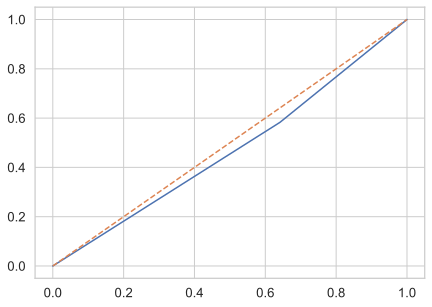

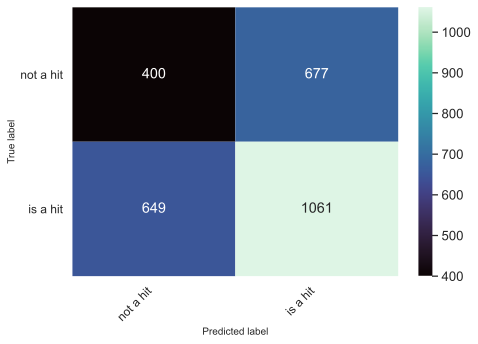

0.6089

In [34]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import learning_curve

dc = DummyClassifier(strategy='stratified')
plot_model(dc,X2_train,y2_train,X2_test,y2_test)
#rocauc(dc,X2_test,y2_test)

<br>

Model 1: Baseline Random Forest Model

The base LR accuracy is: 0.80127
The base LR f1 is: 0.84639
The base LR precision is: 0.80053
The base LR recall is: 0.89798
Precision: 1.0000,   Recall: 1.0000, Accuracy: 1.0000
train error 1.0 test error 0.8400299485700866
y pred proba  [1 1 0 ... 1 1 1]
Precision: 0.7894,   Recall: 0.9012, Accuracy: 0.7919, F1: 0.8416
AUC: 0.8436


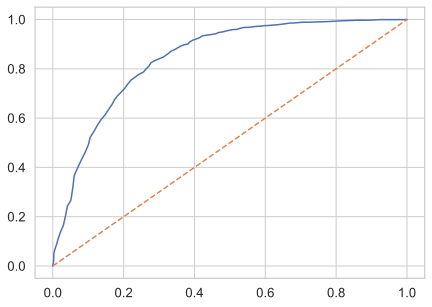

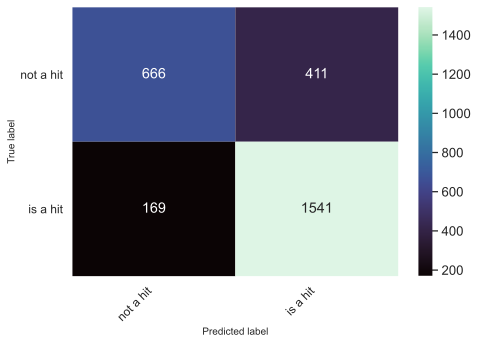

In [35]:
rf1 = RandomForestClassifier(random_state=42,bootstrap=True)
rf1_basef1 = plot_model(rf1, X2_train, y2_train, X2_test, y2_test)

In [28]:
print("Training accuracy score: {:6.4f}".format(rf1.score(X2_train, y2_train)))
print("Testing accuracy score: {:6.4f}".format(rf1.score(X2_test, y2_test)))

Training accuracy score: 1.0000
Testing accuracy score: 0.7937


Results look good however we're overfitting given our training vs. test results

Grid search tuning

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([('classifier', RandomForestClassifier())])

param_grid= [
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(0,9,1))
    }
]
#     'bootstrap': [True],
#     'max_depth': [1,30],
#     'max_features':[3,10],
#     'min_samples_leaf':[3,5],
#     'min_samples_split':[2,5],
#     'n_estimators':[200,500]


# RF instantiate
#forest_reg=RandomForestClassifier(random_state=42) #,class_weight='balanced')

# tunes your hyperparmeters and performs kfold cv
clf = GridSearchCV(pipe,param_grid = param_grid, cv=5, verbose=True, n_jobs=-1)
# RandomizedSearchCV(forest_reg,param_distributions=param_grid,
#                                n_iter=5,cv=5,  random_state=42) #scoring='f1_weighted',

# fits your model on training (applies kfold cv)
#rnd_search.fit(X_train,y_train)
best_clf = clf.fit(X_train,y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  4.7min finished


Check best Parameters

In [ ]:
#rf_mod_est=rnd_search.best_estimator_
print(best_clf.best_params_)
print(best_clf.best_score_)

Model 2: Enter the best paramters into new model

In [ ]:
#With Gridsearch CV results

rf2=RandomForestClassifier(bootstrap=True, 
                           ccp_alpha=0.0,
                           class_weight=None, criterion='gini',
                           max_depth=4, 
                           max_features=2,
                           max_leaf_nodes=None,
                           max_samples=None,
                           min_impurity_decrease=0.0,
                           min_impurity_split=None,
                           min_samples_leaf=1, 
                           min_samples_split=2,
                           min_weight_fraction_leaf=0.0,
                           n_estimators=90,
                           n_jobs=None,
                           oob_score=False,
                           random_state=None,
                           verbose=0, 
                           warm_start=False)
    
# rf2.fit(X2_train, y2_train)
# print("Training accuracy score: {:6.4f}".format(rf2.score(X_train, y_train)))

# y_predict2 = rf2.predict(X_test)

# print("Test Fbeta-score: {:6.4f}".format(fbeta_score(y_test, y_predict2, beta=1.5))) 
# print("Testing accuracy score: {:6.4f}".format(rf2.score(X_test, y_test)))

In [ ]:
#rlr2 = plot_model(rf_mod_est, X2_train, y2_train, X2_test, y2_test)
plot_model(rf2, X2_train, y2_train, X2_test, y2_test)

In [ ]:
print("Training accuracy score: {:6.4f}".format(rf2.score(X2_train, y2_train)))
print("Testing accuracy score: {:6.4f}".format(rf2.score(X2_test, y2_test)))

Much more balanced train/test scores. Can we do better?

Feature importance


In [ ]:
feature_names = X2_train.columns

importances = rf2.feature_importances_

std = np.std([tree.feature_importances_ for tree in rf2.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

ls=feature_names[indices]
print(ls)

# Print the feature ranking
print("Feature ranking:")

for f in range(X2_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1,indices[f] , importances[indices[f]])) 

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X2_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X2_train.shape[1]), ls ,rotation=90) #indices)
plt.xlim([-1, X2_train.shape[1]])

plt.show()

**cols to drop**

In [ ]:
#lr_colsdrop = model_dropcols_opt(lr, X_train, y_train, rlr_basef1, 5, True)

**Refitting based on new cols**

In [ ]:
X3_train = X2_train.drop(['tempo','mode','key'], axis = 1)
X3_test = X2_test.drop(['tempo','mode','key'], axis = 1)
# rlr_secondf1 = plot_model(lr, lr_Xtrain, y2_train, X2_test, y2_test)

In [ ]:
plot_model(rf2, X3_train, y2_train, X3_test, y2_test)

In [ ]:
print("Training accuracy score: {:6.4f}".format(rf2.score(X3_train, y2_train)))
print("Testing accuracy score: {:6.4f}".format(rf2.score(X3_test, y2_test)))

Recall is very high, Precision is lower. We want to balance these. We don't want to miss predicting any hit songs, however we also want to be forward looking and try and produce a hit song.

**check some cases where different**

Change threshold

In [ ]:
plot_model(rf2, X3_train, y2_train, X3_test, y2_test, 0.65)

This is our best model as it balanced both precision and recall and still provides a decent accuracy score.
You want to have balanced precision/recall. Depends on whos asking the question. Could be a big music producer vs. someone independently trying to make a hit on their own. What is the cost? Recall is a greater cost if it's extremely important.

## Tuning Parameters (manual)

** 1. Estimators**

In [ ]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []

for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(X2_train, y2_train)
    train_pred = rf.predict(X2_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y2_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X2_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y2_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

** Max Depth **

In [ ]:
max_depths = np.linspace(1, 15, 15, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(X2_train, y2_train)
    train_pred = rf.predict(X2_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y2_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X2_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y2_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

** min samples split **

In [ ]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []

for min_samples_split in min_samples_splits:
    rf = RandomForestClassifier(min_samples_split=min_samples_split)
    rf.fit(X2_train, y2_train)
    train_pred = rf.predict(X2_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y2_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X2_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y2_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

** min sample leaf **

In [ ]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []

for min_samples_leaf in min_samples_leafs:
    rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
    rf.fit(X2_train, y2_train)
    train_pred = rf.predict(X2_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y2_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X2_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y2_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()


** Feature **

In [ ]:
max_features = list(range(1,10))
train_results = []
test_results = []

for max_feature in max_features:
    rf = RandomForestClassifier(max_features=max_feature)
    rf.fit(X2_train, y2_train)
    train_pred = rf.predict(X2_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y2_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X2_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y2_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

** Fit model based on tuning above **

**Grid search tuning**

** feature importance **


In [ ]:
feature_names = X2_train.columns

importances = rf_mod_est.feature_importances_

std = np.std([tree.feature_importances_ for tree in rf_mod_est.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X2_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1,indices[f] , importances[indices[f]])) 

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X2_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X2_train.shape[1]), feature_names ,rotation=90) #indices)
plt.xlim([-1, X2_train.shape[1]])

plt.show()

**Refitting based on new cols**

In [ ]:
lr_Xtrain = X2_train.drop(['valence','tempo','loudness','track_seconds','liveness'], axis = 1)
#rlr_secondf1 = plot_model(lr, lr_Xtrain, y2_train, X2_test, y2_test)

In [ ]:
param_grid= {
    'bootstrap': [True],
    'max_depth': [1,6],
    'max_features':[3,10],
    'min_samples_leaf':[2,5],
    'min_samples_split':[2,5],
    'n_estimators':[5,50]
    
}

# RF instantiate
forest_reg=RandomForestClassifier(random_state=42) #,class_weight='balanced')

# tunes your hyperparmeters and performs kfold cv
rnd_search = RandomizedSearchCV(forest_reg,param_distributions=param_grid,
                               n_iter=5,cv=5,  random_state=42) #scoring='f1_weighted',

# fits your model on training (applies kfold cv)
rnd_search.fit(lr_Xtrain,y2_train)



**check best estimator**

In [ ]:
rf_mod_est=rnd_search.best_estimator_
# this tells you what the best estimators are for your hpyerparams
from pprint import pprint
#pprint(rnd_search.best_estimator_.get_params())

In [ ]:
rf_mod_est

**obtain scores**

In [ ]:
scores = cross_val_score(rf_mod_est,X2_test,y2_test, cv=5) # , scoring='f1_weighted'
y_pred = cross_val_predict(rf_mod_est,X2_test,y2_test, cv=5) # , scoring='f1_weighted'

In [ ]:
print("Accuracy: %.2f%%" % (scores.mean()*100.0))
print(metrics.classification_report(y2_test,y_pred))

In [ ]:
rlr_finf1 = plot_model(rf_mod_est, X2_train, y2_train, X2_test, y2_test)

In [ ]:
#Random Forest Classifer baseline model

rf = RandomForestClassifier(n_estimators=500, max_depth=3)
rf.fit(X2_train, y2_train)
print("Training accuracy score: {:6.4f}".format(rf.score(X2_train, y2_train)))
print("Testing accuracy score: {:6.4f}".format(rf.score(X2_test, y2_test)))

y1_predict = rf.predict(X2_test)

#f1_score(y_test, y_predict)
print("Test F-score: {:6.4f}".format(f1_score(y2_test, y1_predict)))

** Get scores **

In [ ]:
scores = cross_val_score(rf,X2_test,y2_test, cv=5) # , scoring='f1_weighted'
y_pred = cross_val_predict(rf,X2_test,y2_test, cv=5) # , scoring='f1_weighted'

print("Accuracy: %.2f%%" % (scores.mean()*100.0))
print(metrics.classification_report(y2_test,y_pred))

In [ ]:
# Running RandomForest to find optimal parameters

pipe = Pipeline([('classifier' , RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(0,9,1))}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(X_train, y_train)

In [ ]:
best_clf.best_estimator_

In [ ]:
#With Gridsearch CV results

rf2=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=3, max_features=6,
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=60, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False)
    
rf2.fit(X_train, y_train)
print("Training accuracy score: {:6.4f}".format(rf2.score(X_train, y_train)))

y_predict2 = rf2.predict(X_test)

print("Test Fbeta-score: {:6.4f}".format(fbeta_score(y_test, y_predict2, beta=1.5))) 
print("Testing accuracy score: {:6.4f}".format(rf2.score(X_test, y_test)))

** plot multiple auc curves **

In [ ]:

classifiers = [lm, 
               rf2,
              VotingClassifier(estimators=[('lr', model1), ('rf', model2)], voting='soft')]

# Define a result table as a DataFrame

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results

for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels

result_table.set_index('classifiers', inplace=True)

In [ ]:
In [38]:
result_table

In [ ]:
#Plot three ROC Curves (LR, NB, RF)

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

fig.savefig('ROC_curve.png')

**TESTING**

In [ ]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause


RANDOM_STATE = 123

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

**GOOD for selecting new inputs as examples**

In [ ]:
from sklearn.preprocessing import StandardScaler
#features = ['danceability','valence','loudness','tempo','energy','key','acousticness','speechiness']# ,
       #'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       #'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']

features = ['acousticness','danceability','energy','loudness','valence','track_seconds']
labels = ['is_hit']        

# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()

#X_train = scaler.fit_transform(df_train[features])
X_train = df_train[features]
y_train = df_train[labels]

X_test = df_test[features]
y_test = df_test['is_hit']

**Fit your model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn import metrics


param_grid= {
    'bootstrap': [True]#,
    #'max_depth': [50,100],
    #'max_features':[3,8],
    #'min_samples_leaf':[3,5],
    #'min_samples_split':[2,5],
    #'n_estimators':[300,500]
    
}

# RF instantiate
forest_reg=RandomForestClassifier(random_state=42) #,class_weight='balanced')

# tunes your hyperparmeters and performs kfold cv
rnd_search = RandomizedSearchCV(forest_reg,param_distributions=param_grid,
                               n_iter=5,cv=5,  random_state=42) #scoring='f1_weighted',

# fits your model on training (applies kfold cv)
rnd_search.fit(X_train,y_train)



**check best estimator**

In [ ]:
rf_mod_est=rnd_search.best_estimator_

# this tells you what the best estimators are for your hpyerparams
from pprint import pprint
#pprint(rnd_search.best_estimator_.get_params())

In [ ]:
rf_mod_est

**obtain scores**

In [ ]:
scores = cross_val_score(rf_mod_est,X_train,y_train, cv=5) # , scoring='f1_weighted'
y_pred = cross_val_predict(rf_mod_est,X_train,y_train, cv=5) # , scoring='f1_weighted'

In [ ]:
print("Accuracy: %.2f%%" % (scores.mean()*100.0))
print(metrics.classification_report(y_train,y_pred))

**same as above - different way to display scores**

In [ ]:
def display_scores(scores):
    print("scores:",scores)
    print("mean:",scores.mean())
    print("standard dev:",scores.std())
    
print("Validation Dataset")    
display_scores(scores)

**Exact same thing as above - just testing really**

In [ ]:
# this fits the model and gets us an accuracy scores (only gets scores)
results_skfold = model_selection.cross_val_score(rf_mod_est, X_train, y_train, cv=5)
predict_skfold = model_selection.cross_val_predict(rf_mod_est, X_train, y_train, cv=5)

print("Accuracy: %.2f%%" % (results_skfold.mean()*100.0))
print(metrics.classification_report(y_train,predict_skfold))

**ROC/AUC**

In [ ]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = rf_mod_est.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend()

plt.savefig('aucroc_rf.png',bbox_inches='tight')

# show the plot
pyplot.show()

**Confusion Matrix**

In [ ]:
preds_ovr = rf_mod_est.predict(X_test)

In [ ]:
confusion_matrix(y_test,preds_ovr)

**Trying a heatmap to show predictions - confusion matrix (on ovr)**

In [ ]:
from sklearn.metrics import confusion_matrix

labels = [0,1]
cm = confusion_matrix(y_test, preds_ovr, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confmx_Rf.png',bbox_inches='tight')
plt.show()


In [ ]:
# new instances where we do not know the answer
Xnew, _ = make_blobs(n_samples=3, centers=2, n_features=2, random_state=1)
# make a prediction
ynew = model.predict(Xnew)
# show the inputs and predicted outputs
for i in range(len(Xnew)):
	print("X=%s, Predicted=%s" % (Xnew[i], ynew[i]))